In [1]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt

In [2]:
class UCBLikeAgent():
    def __init__(self, num_prices, B, T):
        self.num_prices = num_prices
        self.T = T
        self.p_index_t = None # it's an index, not the actual bid
        self.avg_f_t = np.zeros(num_prices)
        self.avg_c_t = np.zeros(num_prices)
        self.N_pulls = np.zeros(num_prices)
        self.remaining_budget = B
        self.rho = B/T
        self.t = 0
    
    def pull_arm(self) -> int:
        if self.remaining_budget < 1:  # if the budget is depleted, we cannot pull any arm
            raise BudgetDepletedException()
        if self.t < self.num_prices:  # explore at least once each arm
            self.p_index_t = self.t 
        else:
            f_ucbs_t = self.avg_f_t + np.sqrt(2*np.log(self.T)/self.N_pulls)  # TODO: try also with self.T - self.t
            c_lcbs_t = self.avg_c_t - np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.p_index_t = self.compute_opt(f_ucbs_t, c_lcbs_t)
        return self.p_index_t

    def compute_opt(self, f_ucbs, c_lcbs):
        mask = c_lcbs <= np.ones(len(c_lcbs)) * self.rho
        best_p_index = np.argmax(f_ucbs * mask)
        return best_p_index
    
    def update(self, f_t, c_t):
        self.N_pulls[self.p_index_t] += 1
        self.avg_f_t[self.p_index_t] += (f_t - self.avg_f_t[self.p_index_t])/self.N_pulls[self.p_index_t]
        self.avg_c_t[self.p_index_t] += (c_t - self.avg_c_t[self.p_index_t])/self.N_pulls[self.p_index_t]
        self.remaining_budget -= c_t
        self.t += 1


class BudgetDepletedException(RuntimeError):
    pass

In [3]:
class Environment:
    def __init__(self, mean, std, T):
        self.valuations = np.random.normal(mean, std, size=T)

    def round(self, t, p_t) -> bool:
        return self.valuations[t] >= p_t

In [4]:
from dataclasses import dataclass
from typing import Collection

@dataclass
class SimulationConfig:
    num_rounds: int
    prices: Collection[float | int]
    total_budget: int | float

@dataclass
class SingleSimulationResult:
    best_price: float
    agent_rewards: np.ndarray
    baseline_rewards: np.ndarray
    budget_depleted_round: int

@dataclass
class AggregatedSimulationResult:
    cumulative_regrets: np.ndarray
    total_baseline_rewards: np.ndarray
    total_agent_rewards: np.ndarray
    budget_depleted_mean_round: float
    best_prices: np.ndarray

In [ ]:
# TODO: possiamo utilizzare una funzione get_baseline. Guarda req2.py
def get_best_price(env, config: SimulationConfig):
    best_p = config.prices[0]
    best_f = 0
    for p in config.prices:
        f = min(np.sum(env.valuations >= p), config.total_budget) * p
        if f > best_f:
            best_f = f
            best_p = p
    return best_p

def get_baseline_rewards(env, config: SimulationConfig):
    best_p = get_best_price(env, config)
    mask = env.valuations >= best_p
    # TODO: explain it a little bit
    return (np.cumsum(mask) <= config.total_budget) * mask * best_p

In [ ]:
def run_simulation(agent, env, config: SimulationConfig) -> SingleSimulationResult:
    agent_rewards = np.array([])
    best_p = get_best_price(env, config)
    baseline_rewards = get_baseline_rewards(env, config)
    budget_depleted_round = -1
    try:
        for t in range(config.num_rounds):
            p_index_t = agent.pull_arm()
            p_t = config.prices[p_index_t]
            bought = env.round(t, p_t)
            f_t = p_t if bought else 0
            c_t = 1 if bought else 0
            agent.update(f_t, c_t)
            agent_rewards = np.append(agent_rewards, f_t)
    except BudgetDepletedException:
        agent_rewards = np.append(agent_rewards, np.zeros(config.num_rounds-len(agent_rewards)))
    finally:
        budget_depleted_round = agent.t
    return SingleSimulationResult(
        agent_rewards=agent_rewards,
        baseline_rewards=baseline_rewards,
        budget_depleted_round=budget_depleted_round,
        best_price=best_p
    )

def simulate(agent_builder: callable, env_builder: callable, config: SimulationConfig, n_trials) -> AggregatedSimulationResult:
    cumulative_regrets = np.zeros((n_trials, config.num_rounds))
    total_baseline_rewards = np.zeros((n_trials, config.num_rounds))
    total_agent_rewards = np.zeros((n_trials, config.num_rounds))
    budget_depleted_rounds = np.zeros(n_trials, dtype=int)
    best_prices = np.zeros(n_trials)
    for i in range(n_trials):
        print(f"Running trial {i+1}")

        agent = agent_builder()
        env = env_builder()
        simulation_result = run_simulation(agent, env, config)

        regret = simulation_result.baseline_rewards - simulation_result.agent_rewards
        cumulative_regret = np.cumsum(regret)

        cumulative_regrets[i] = cumulative_regret
        total_baseline_rewards[i] = simulation_result.baseline_rewards
        total_agent_rewards[i] = simulation_result.agent_rewards
        budget_depleted_rounds[i] = simulation_result.budget_depleted_round
        best_prices[i] = simulation_result.best_price
    
    return AggregatedSimulationResult(
        cumulative_regrets=cumulative_regrets,
        total_baseline_rewards=total_baseline_rewards,
        total_agent_rewards=total_agent_rewards,
        budget_depleted_mean_round=np.mean(budget_depleted_rounds),
        best_prices=best_prices
    )

In [6]:
def show_regret(cumulative_regrets, rounds_per_trial, n_trials):
    average_regret = cumulative_regrets.mean(axis=0)
    regret_sd = cumulative_regrets.std(axis=0)

    plt.plot(np.arange(rounds_per_trial), average_regret, label='Average Regret')
    plt.title('Cumulative regret of Random Player')
    plt.fill_between(np.arange(rounds_per_trial),
                    average_regret-regret_sd/np.sqrt(n_trials),
                    average_regret+regret_sd/np.sqrt(n_trials),
                    alpha=0.3,
                    label='Uncertainty')
    plt.xlabel('$t$')
    plt.legend()

def show_cumulative_rewards(total_baseline_rewards, rounds_per_trial, total_agent_rewards, budget_depleted_mean_round):
    cumulative_baseline_rewards = total_baseline_rewards.cumsum(axis=1)
    cumulative_agent_rewards = total_agent_rewards.cumsum(axis=1)
    plt.plot(np.arange(rounds_per_trial), cumulative_baseline_rewards.mean(axis=0), label='Average Baseline Rewards')
    plt.plot(np.arange(rounds_per_trial), cumulative_agent_rewards.mean(axis=0), label='Average Agent Rewards')
    plt.axvline(x=budget_depleted_mean_round, color='red', linestyle='--', label='Budget Depleted Round')
    plt.legend()
    plt.title('Cumulative Rewards')
    plt.xlabel('$t$')

def show_histogram(result: AggregatedSimulationResult):
    unique_counts = np.array(np.unique_counts(result.total_agent_rewards))
    plt.bar(unique_counts[0][1:], unique_counts[1][1:], width=0.7)
    plt.title('Histogram of Agent Prices')
    plt.xlabel('Agent Prices')
    plt.ylabel('Frequency')

def plot_statistics(result: AggregatedSimulationResult, rounds_per_trial: int, n_trials: int):
    print(f"Average budget depleted round from the agent: {result.budget_depleted_mean_round}")
    print(f"Best price for the baseline: {result.best_prices.mean()} with std {result.best_prices.std()}")
    print(f"Average total regret: {result.cumulative_regrets[..., -1].mean()}")
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    show_regret(result.cumulative_regrets, rounds_per_trial, n_trials)
    plt.subplot(2, 2, 2)
    show_cumulative_rewards(result.total_baseline_rewards, rounds_per_trial, result.total_agent_rewards, result.budget_depleted_mean_round)
    plt.subplot(2, 2, 3)
    show_histogram(result)

In [17]:
n_trials = 10

P = list(range(5, 26))
B = 300
T = 1200

simulation_config = SimulationConfig(
    num_rounds=T,
    prices=P,
    total_budget=B
)

env_builder = lambda: Environment(mean=15, std=5, T=T)

Average budget depleted round from the agent: 453.11
Best price for the baseline: 18.01 with std 0.09949874371066196
Average total regret: 2044.87


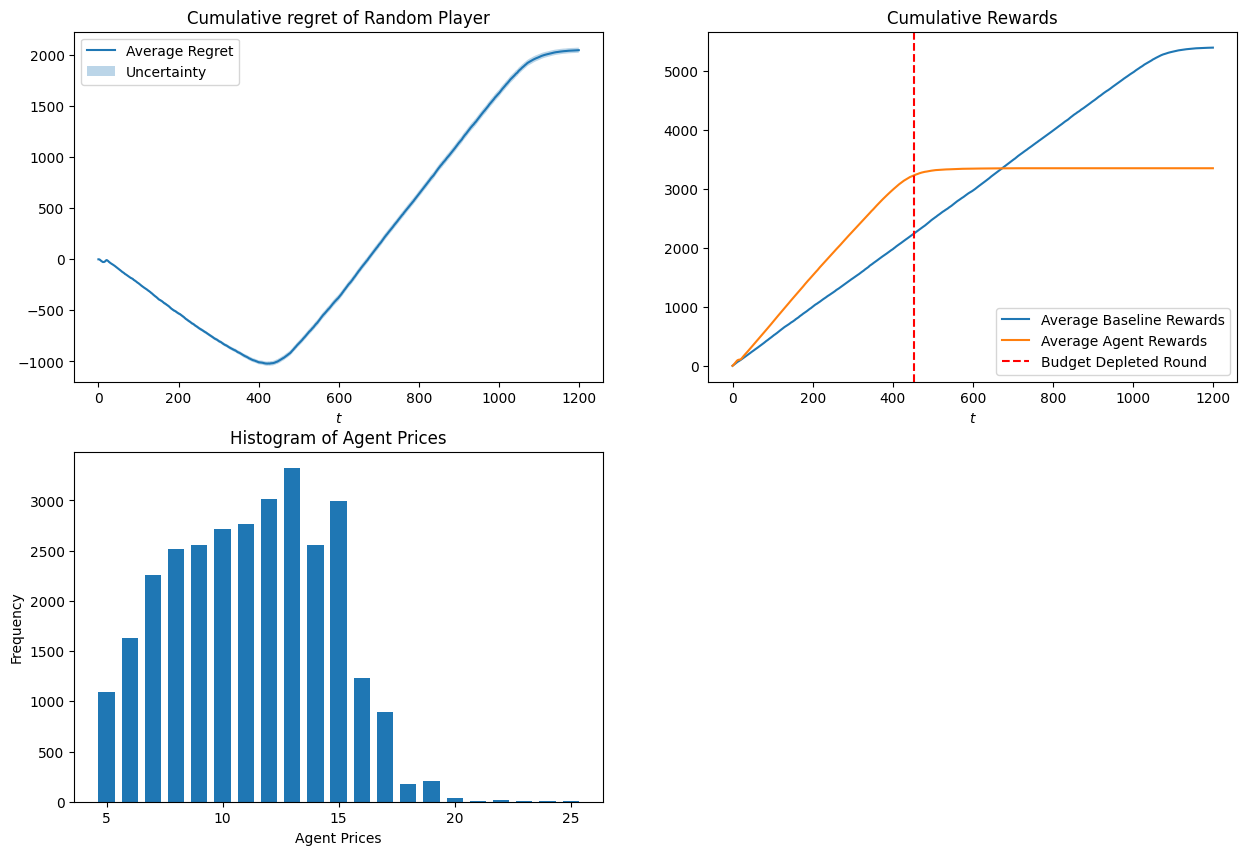

In [8]:
result = simulate(
    agent_builder=lambda: UCBLikeAgent(num_prices=len(P), B=B, T=T),
    env_builder=env_builder,
    config=simulation_config,
    n_trials=n_trials
)
plot_statistics(result, rounds_per_trial=T, n_trials=n_trials)

In [9]:
class UCBLikeAgentWithDynamicRho():
    def __init__(self, num_prices, B, T, beta=1):
        self.num_prices = num_prices
        self.T = T
        self.p_index_t = None # it's an index, not the actual bid
        self.avg_f_t = np.zeros(num_prices)
        self.avg_c_t = np.zeros(num_prices)
        self.N_pulls = np.zeros(num_prices)
        self.remaining_budget = B
        self.rho = B/T
        self.t = 0
        self.beta = beta
    
    def pull_arm(self) -> int:
        if self.remaining_budget < 1:  # if the budget is depleted, we cannot pull any arm
            raise BudgetDepletedException()
        if self.t < self.num_prices:  # explore at least once each arm
            self.p_index_t = self.t 
        else:
            f_ucbs_t = self.avg_f_t + self.beta * np.sqrt(np.log(self.T)/self.N_pulls)
            c_lcbs_t = self.avg_c_t - self.beta * np.sqrt(np.log(self.T)/self.N_pulls)
            self.p_index_t = self.compute_opt(f_ucbs_t, c_lcbs_t)
        return self.p_index_t

    def compute_opt(self, f_ucbs, c_lcbs):
        mask = c_lcbs <= np.ones(len(c_lcbs)) * self.rho
        best_p_index = np.argmax(f_ucbs * mask)
        return best_p_index
    
    def update(self, f_t, c_t):
        self.N_pulls[self.p_index_t] += 1
        self.avg_f_t[self.p_index_t] += (f_t - self.avg_f_t[self.p_index_t])/self.N_pulls[self.p_index_t]
        self.avg_c_t[self.p_index_t] += (c_t - self.avg_c_t[self.p_index_t])/self.N_pulls[self.p_index_t]
        self.remaining_budget -= c_t
        self.rho = self.remaining_budget / (self.T - self.t) if (self.T - self.t) > 0 else 0
        self.t += 1

Average budget depleted round from the agent: 1199.21
Best price for the baseline: 17.99 with std 0.09949874371066196
Average total regret: 304.11


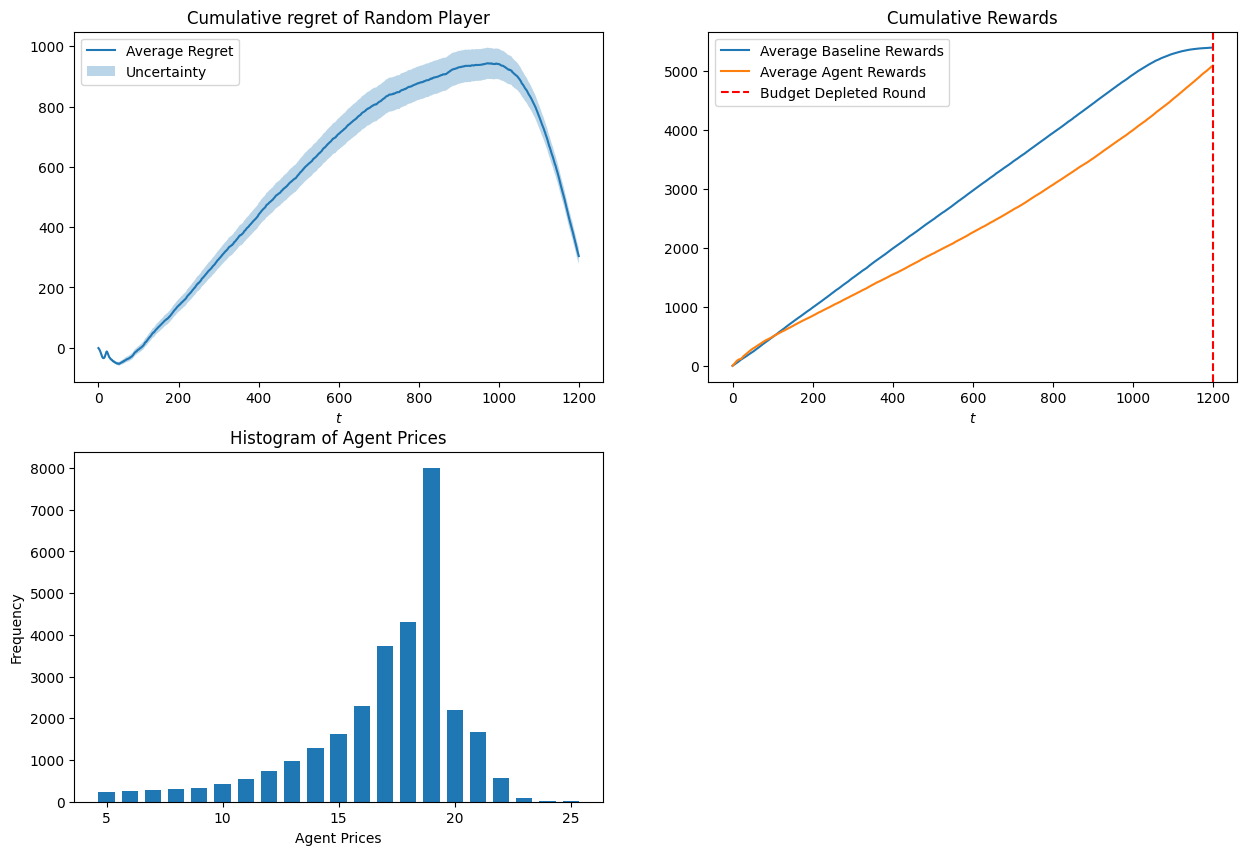

In [10]:
result = simulate(
    agent_builder=lambda: UCBLikeAgentWithDynamicRho(num_prices=len(P), B=B, T=T, beta=0.3),
    env_builder=env_builder,
    config=simulation_config,
    n_trials=n_trials
)
plot_statistics(result, rounds_per_trial=T, n_trials=n_trials)

In [ ]:
from scipy.optimize import linprog

class UCBLikeAgentWithLP():
    def __init__(self, num_prices, B, T, beta=1):
        self.num_prices = num_prices
        self.T = T
        self.p_index_t = None # it's an index, not the actual bid
        self.avg_f_t = np.zeros(num_prices)
        self.avg_c_t = np.zeros(num_prices)
        self.N_pulls = np.zeros(num_prices)
        self.remaining_budget = B
        self.rho = B/T
        self.t = 0
        self.beta = beta
    
    def pull_arm(self) -> int:
        if self.remaining_budget < 1:  # if the budget is depleted, we cannot pull any arm
            raise BudgetDepletedException()
        if self.t < self.num_prices:  # explore at least once each arm
            self.p_index_t = self.t 
        else:
            f_ucbs_t = self.avg_f_t + self.beta * np.sqrt(np.log(self.T)/self.N_pulls)
            c_lcbs_t = self.avg_c_t - self.beta * np.sqrt(np.log(self.T)/self.N_pulls)
            gamma_t = self.compute_opt(f_ucbs_t, c_lcbs_t)
            self.p_index_t = np.random.choice(self.num_prices, p=gamma_t)
        return self.p_index_t

    # TODO:
    # Questa funzione l'ha fatta gemini, ma in realta' di diverso dal prof fa solo la parte di post processing
    # Dobbiamo capire bene perche' questo performa bene mentre quello del prof no, con questi iperparametri
    # aveva 2000 di average total regret
    def compute_opt(self, f_ucbs, c_lcbs):
        """
        Solves the LP to find the optimal probability distribution gamma_t.
        """
        num_prices = self.num_prices
        rho = self.rho

        # --- Robustness Check: Handle Infeasibility ---
        # If the minimum possible cost is still greater than our spend rate,
        # the LP is infeasible. No mix of arms can meet the budget.
        # In this case, we must be conservative and play the arm with the
        # absolute lowest LCB cost to preserve the budget.
        if np.min(c_lcbs) > rho:
            best_p_index = np.argmin(c_lcbs)
            gamma_t = np.zeros(num_prices)
            gamma_t[best_p_index] = 1.0
            return gamma_t

        # --- LP Formulation ---
        # Objective: Maximize sum(gamma * f_ucbs)
        # Since linprog is a minimizer, we minimize -sum(gamma * f_ucbs)
        c = -f_ucbs

        # Constraints:
        # 1. Budget constraint: sum(gamma * c_lcbs) <= rho
        A_ub = [c_lcbs]
        b_ub = [rho]

        # 2. Probability constraint: sum(gamma) = 1
        A_eq = [np.ones(num_prices)]
        b_eq = [1]

        # Bounds for gamma (each probability is between 0 and 1)
        bounds = (0, 1)

        # --- Solve the LP ---
        result = linprog(c=c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

        # --- Post-processing and Final Fallback ---
        if result.success:
            gamma_t = result.x
            # Sanitize the results due to potential floating point inaccuracies
            gamma_t = np.maximum(0, gamma_t) # Ensure no negative probabilities
            gamma_t /= np.sum(gamma_t)      # Ensure it sums exactly to 1
            return gamma_t
        else:
            # If the solver fails for any other reason, fall back to the
            # robust greedy strategy as a safeguard.
            mask = c_lcbs <= rho
            masked_f_ucbs = np.where(mask, f_ucbs, -np.inf)
            best_p_index = np.argmax(masked_f_ucbs)
            gamma_t = np.zeros(num_prices)
            gamma_t[best_p_index] = 1.0
            return gamma_t

    def update(self, f_t, c_t):
        self.N_pulls[self.p_index_t] += 1
        self.avg_f_t[self.p_index_t] += (f_t - self.avg_f_t[self.p_index_t])/self.N_pulls[self.p_index_t]
        self.avg_c_t[self.p_index_t] += (c_t - self.avg_c_t[self.p_index_t])/self.N_pulls[self.p_index_t]
        self.remaining_budget -= c_t
        self.rho = self.remaining_budget / (self.T - self.t) if (self.T - self.t) > 0 else 0
        self.t += 1

Running trial 1
Running trial 2
Running trial 3
Running trial 4
Running trial 5
Running trial 6
Running trial 7
Running trial 8
Running trial 9
Running trial 10
Average budget depleted round from the agent: 1177.5
Best price for the baseline: 18.0 with std 0.0
Average total regret: 282.0


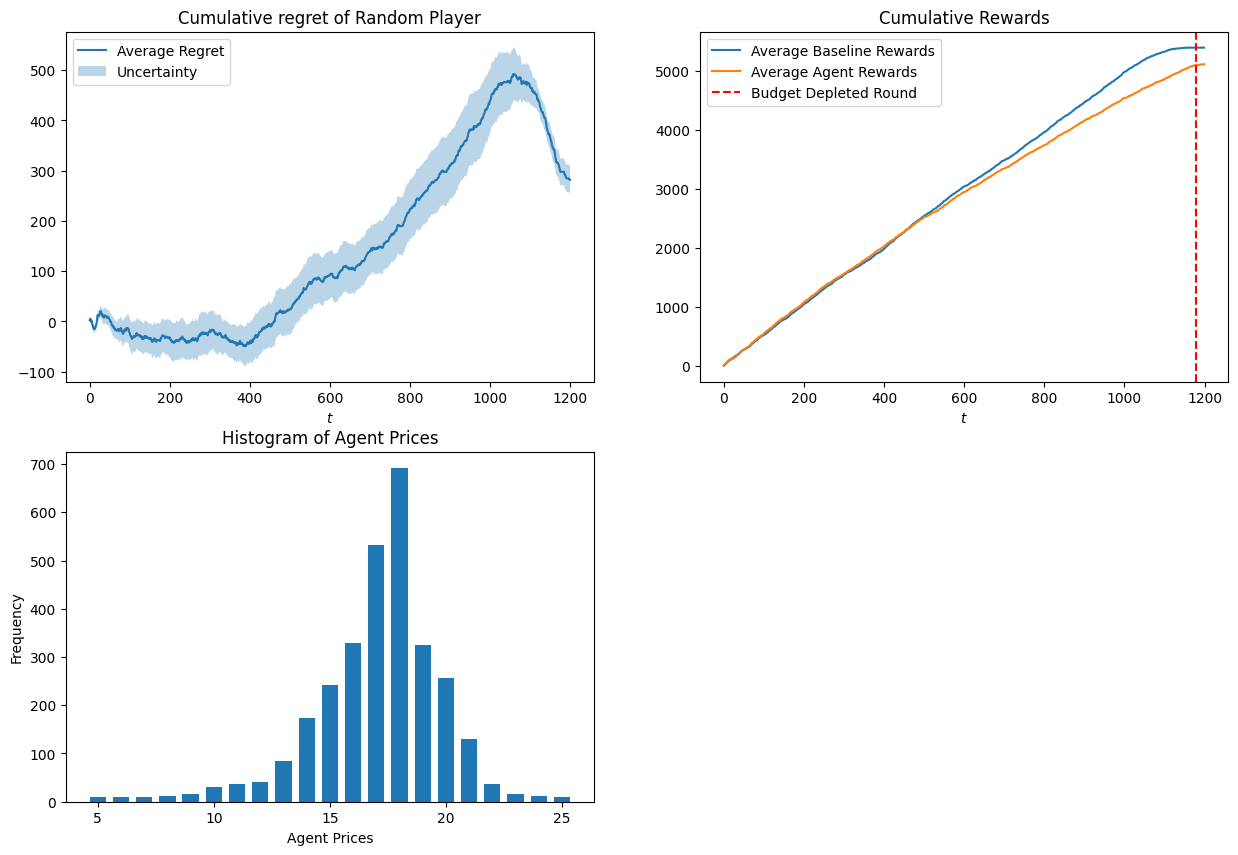

In [23]:
result = simulate(
    agent_builder=lambda: UCBLikeAgentWithLP(num_prices=len(P), B=B, T=T, beta=0.15),
    env_builder=env_builder,
    config=simulation_config,
    n_trials=n_trials
)
plot_statistics(result, rounds_per_trial=T, n_trials=n_trials)